In [ ]:
 !pip3 install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
 !pip3 install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 63.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import torch.nn.functional as F
from torch.optim import Adam
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from tqdm import tqdm

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5);

In [ ]:
pol_df = pd.read_csv(
    '/content/sample_data/daily_42401_2017.csv')
pol_df.head(5)

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
0,1,73,23,42401,2,33.553056,-86.815,WGS84,Sulfur dioxide,1 HOUR,...,3.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",Alabama,Jefferson,Birmingham,"Birmingham-Hoover, AL",2018-02-21
1,1,73,23,42401,2,33.553056,-86.815,WGS84,Sulfur dioxide,1 HOUR,...,6.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",Alabama,Jefferson,Birmingham,"Birmingham-Hoover, AL",2018-02-21
2,1,73,23,42401,2,33.553056,-86.815,WGS84,Sulfur dioxide,1 HOUR,...,0.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",Alabama,Jefferson,Birmingham,"Birmingham-Hoover, AL",2018-02-21
3,1,73,23,42401,2,33.553056,-86.815,WGS84,Sulfur dioxide,1 HOUR,...,1.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",Alabama,Jefferson,Birmingham,"Birmingham-Hoover, AL",2018-02-21
4,1,73,23,42401,2,33.553056,-86.815,WGS84,Sulfur dioxide,1 HOUR,...,16.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",Alabama,Jefferson,Birmingham,"Birmingham-Hoover, AL",2018-02-21


In [ ]:
pol_df
samp = pol_df.loc[pol_df['Latitude'].notnull()]
map_sample = folium.Map(location=[50,-85], zoom_start=3)
HeatMap(data=samp[['Latitude', 'Longitude']], radius=10).add_to(map_sample)
map_sample

In [ ]:
to_drop = ['State Code', 'County Code', 'Site Num',
           'Parameter Code', 'Latitude', 'Longitude',
          'Parameter Name', 'Sample Duration',
           'Pollutant Standard']
df = pol_df.drop(to_drop, axis=1)
df.tail()

,POC,Datum,Date Local,Units of Measure,Event Type,Observation Count,Observation Percent,Arithmetic Mean,1st Max Value,1st Max Hour,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
19166,9,WGS84,2017-01-25,Parts per billion,None,8,100.0,0.4000,0.6,5,NaN,NaN,-,Los Angeles-North Main Street,"1630 N MAIN ST, LOS ANGELES",California,Los Angeles,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",2018-03-13
19167,9,WGS84,2017-01-26,Parts per billion,None,8,100.0,0.4625,0.6,5,NaN,NaN,-,Los Angeles-North Main Street,"1630 N MAIN ST, LOS ANGELES",California,Los Angeles,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",2018-03-13
19168,9,WGS84,2017-01-27,Parts per billion,None,8,100.0,0.6250,1.1,8,NaN,NaN,-,Los Angeles-North Main Street,"1630 N MAIN ST, LOS ANGELES",California,Los Angeles,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",2018-03-13
19169,9,WGS84,2017-01-28,Parts per billion,None,8,100.0,0.6625,0.9,8,NaN,NaN,-,Los Angeles-North Main Street,"1630 N MAIN ST, LOS ANGELES",California,Los Angeles,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",2018-03-13
19170,9,WGS84,2017-01-29,Parts per billion,None,8,100.0,0.6000,0.9,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def get_uniques(df):

    for col in df.columns:
        if df[col].dtype=='object' and col != 'Date Local':
            print(f'Unique values for {col}: {df[col].unique()}')

get_uniques(df)

Unique values for Datum: ['WGS84' 'NAD83']
Unique values for Units of Measure: ['Parts per billion']
Unique values for Event Type: ['None']
Unique values for Method Name: ['INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE' ' - '
 'INSTRUMENTAL - PULSED FLUORESCENT'
 'INSTRUMENTAL - Pulsed Fluorescent 43C-TLE/43i-TLE'
 'Instrumental - Ultraviolet Fluorescence EC9850T' nan]
Unique values for Local Site Name: ['North Birmingham' 'Fairfield' 'Sloss Shuttlesworth' 'CHICKASAW'
 'Lhoist, Montevallo Plant' 'NCORE' 'MIAMI RIDGELINE' 'Miami Jones Ranch'
 'Miami Townsite' 'HAYDEN OLD JAIL' 'CENTRAL PHOENIX' 'DURANGO COMPLEX'
 'JLG SUPERSITE' "CHILDREN'S PARK NCore" 'PARR' 'Oakland West' 'Concord'
 'Richmond - 7th St.' 'Crockett - Kendall Ave' 'Bethel Island' 'San Pablo'
 'Martinez - Jones St.' 'Fresno - Garland' 'Jacobs' 'Humboldt Hill'
 'Calexico-Ethel Street'
 'White Mountain Research Center - Owens Valley Lab'
 'Los Angeles-North Main Street' nan]
Unique values for Address: ["NO. B'HAM,SOU R.R., 3009 2

In [ ]:
df.drop(['Datum', 'Units of Measure', 'Event Type',
         'State Name', 'County Name', 'City Name',
        'CBSA Name'], axis=1, inplace=True)
df.loc[:, 'Date Local'] = pd.to_datetime(df['Date Local'])
df.set_index('Date Local', inplace=True)
df

<ipython-input-12-8b1c415b888a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Date Local'] = pd.to_datetime(df['Date Local'])


,POC,Observation Count,Observation Percent,Arithmetic Mean,1st Max Value,1st Max Hour,AQI,Method Code,Method Name,Local Site Name,Address,Date of Last Change
Date Local,,,,,,,,,,,,
2017-01-04,2,9,38.0,0.366667,2.0,22,3.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",2018-02-21
2017-01-05,2,19,79.0,0.826316,4.7,6,6.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",2018-02-21
2017-01-06,2,21,88.0,0.285714,0.8,12,0.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",2018-02-21
2017-01-07,2,24,100.0,0.833333,1.9,14,1.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",2018-02-21
2017-01-08,2,24,100.0,2.108333,11.6,8,16.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",2018-02-21
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-25,9,8,100.0,0.400000,0.6,5,NaN,NaN,-,Los Angeles-North Main Street,"1630 N MAIN ST, LOS ANGELES",2018-03-13
2017-01-26,9,8,100.0,0.462500,0.6,5,NaN,NaN,-,Los Angeles-North Main Street,"1630 N MAIN ST, LOS ANGELES",2018-03-13
2017-01-27,9,8,100.0,0.625000,1.1,8,NaN,NaN,-,Los Angeles-North Main Street,"1630 N MAIN ST, LOS ANGELES",2018-03-13


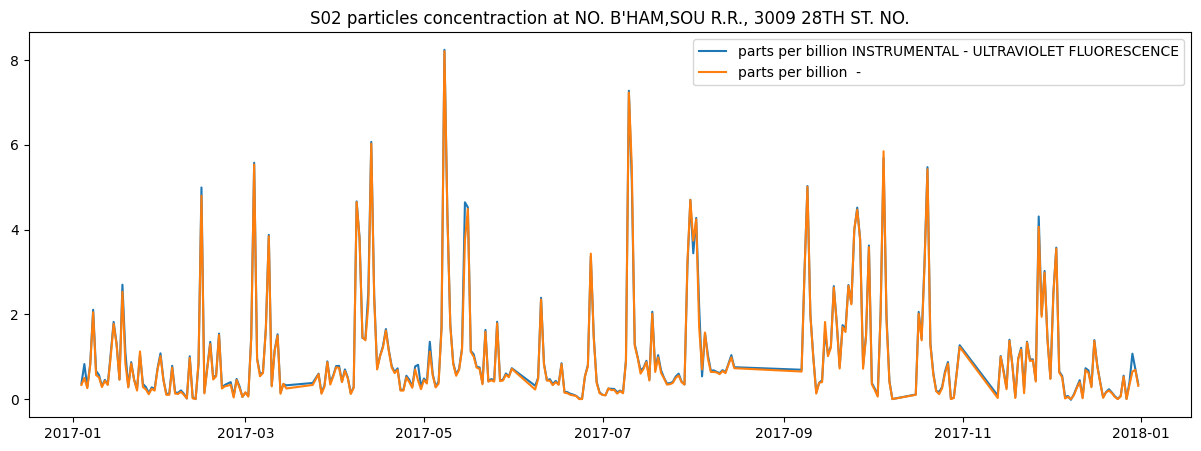

In [ ]:
t11 = df.loc[(df['Address']==df['Address'].unique()[0]) & (
    df['Method Name']==df['Method Name'].unique()[0])]
t12 = df.loc[(df['Address']==df['Address'].unique()[0]) & (
    df['Method Name']==df['Method Name'].unique()[1])]
t21 = df.loc[(df['Address']==df['Address'].unique()[1]) & (
    df['Method Name']==df['Method Name'].unique()[0])]
t22 = df.loc[(df['Address']==df['Address'].unique()[1]) & (
    df['Method Name']==df['Method Name'].unique()[1])]
plt.plot(t11['Arithmetic Mean'], label='parts per billion {}'.format(t11['Method Name'][0]))
plt.plot(t12['Arithmetic Mean'], label='parts per billion {}'.format(t12['Method Name'][0]))
plt.title('S02 particles concentraction at {}'.format(t11['Address'][0]))
plt.legend()

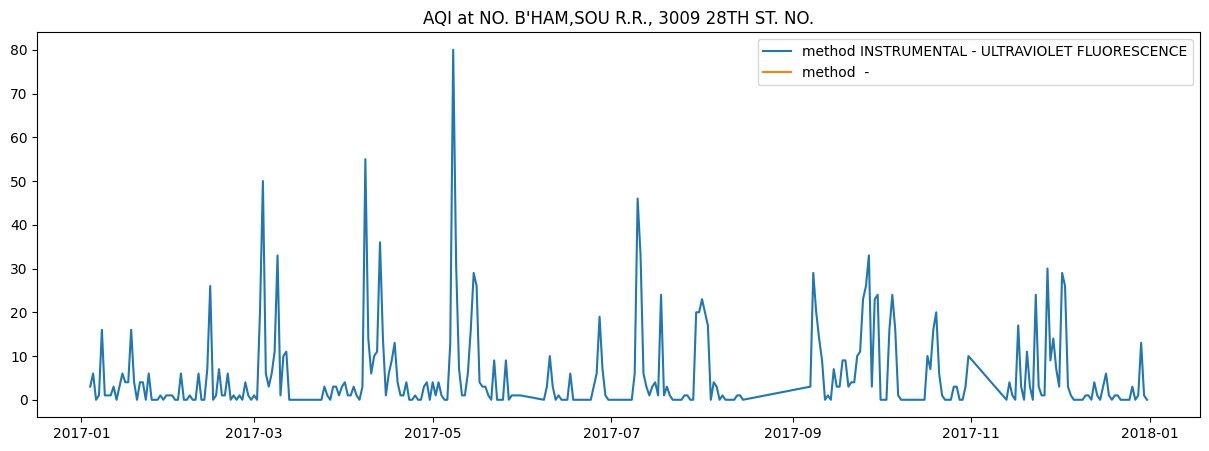

In [ ]:
plt.plot(t11['AQI'], label='method {}'.format(t11['Method Name'][0]))
plt.plot(t12['AQI'], label='method {}'.format(t12['Method Name'][0]))
plt.title('AQI at {}'.format(t11['Address'][0]))
plt.legend()

In [ ]:
df = df.loc[(df['Address']==df['Address'].unique()[0]) & (
    df['Method Name']==df['Method Name'].unique()[0])]
df

,POC,Observation Count,Observation Percent,Arithmetic Mean,1st Max Value,1st Max Hour,AQI,Method Code,Method Name,Local Site Name,Address,Date of Last Change
Date Local,,,,,,,,,,,,
2017-01-04,2,9,38.0,0.366667,2.0,22,3.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",2018-02-21
2017-01-05,2,19,79.0,0.826316,4.7,6,6.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",2018-02-21
2017-01-06,2,21,88.0,0.285714,0.8,12,0.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",2018-02-21
2017-01-07,2,24,100.0,0.833333,1.9,14,1.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",2018-02-21
2017-01-08,2,24,100.0,2.108333,11.6,8,16.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",2018-02-21
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,2,21,88.0,0.009524,0.1,14,0.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",2018-02-21
2017-12-28,2,22,92.0,0.395455,1.1,10,1.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",2018-02-21
2017-12-29,2,21,88.0,1.071429,9.9,11,13.0,100.0,INSTRUMENTAL - ULTRAVIOLET FLUORESCENCE,North Birmingham,"NO. B'HAM,SOU R.R., 3009 28TH ST. NO.",2018-02-21


In [ ]:
df.drop(['Address', 'Method Name', 'Method Code', 'Local Site Name',
         'Date of Last Change', 'POC', 'Observation Count',
         'Observation Percent', '1st Max Hour'], axis=1, inplace=True)
df

<ipython-input-16-e8bca0dc590b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Address', 'Method Name', 'Method Code', 'Local Site Name',


,Arithmetic Mean,1st Max Value,AQI
Date Local,,,
2017-01-04,0.366667,2.0,3.0
2017-01-05,0.826316,4.7,6.0
2017-01-06,0.285714,0.8,0.0
2017-01-07,0.833333,1.9,1.0
2017-01-08,2.108333,11.6,16.0
...,...,...,...
2017-12-27,0.009524,0.1,0.0
2017-12-28,0.395455,1.1,1.0
2017-12-29,1.071429,9.9,13.0


In [ ]:
df.isnull().sum()

Arithmetic Mean    0
1st Max Value      0
AQI                0
dtype: int64

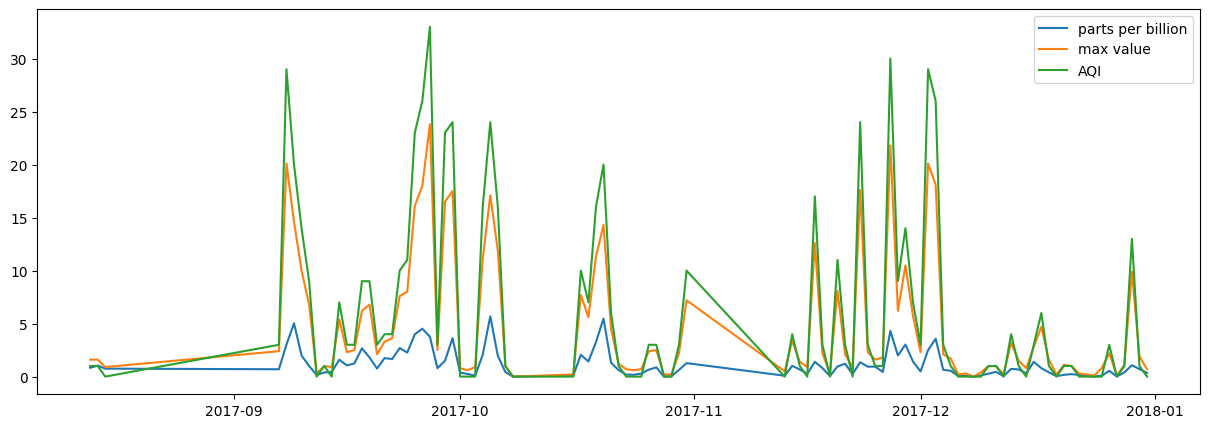

In [ ]:
# inputer_data = df.loc[df['AQI'].notnull()]
plt.plot(df.dropna()['Arithmetic Mean'][-100:], label='parts per billion')
plt.plot(df.dropna()['1st Max Value'][-100:], label='max value')
plt.plot(df.dropna()['AQI'][-100:], label='AQI')
plt.legend(loc = 'upper right')

In [ ]:
def inpute_aqi(aqi, max_values, mv_pred, epochs=50):
    linreg = nn.Linear(1, 1)
    loss_f = F.mse_loss #.l1_loss
    opt = torch.optim.Adam(linreg.parameters(), lr=0.0001)
    if isinstance(aqi, np.ndarray):
        aqi_max = np.max(aqi)
        aqi = torch.from_numpy(aqi/aqi_max)
    if isinstance(max_values, np.ndarray):
        max_values_max = np.max(max_values)
        max_values = torch.from_numpy(max_values/max_values_max)
    if isinstance(mv_pred, np.ndarray):
        mv_pred_max = np.max(mv_pred)
        mv_pred = torch.from_numpy(mv_pred/max_values_max)
    for epoch in range(0, epochs):

        # Train with batches of data
        for x, y in zip(aqi, max_values):
            #print(x, y)
            out = F.relu(linreg(x))
            loss = loss_f(out, y)
            loss.backward()
            opt.step()
            opt.zero_grad()
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(
                epoch+1, epochs, loss.item()))
    l = [round(linreg(x).item()*max_values_max) for x in mv_pred]
    return l

# if you have NaN values for AQI use similar procedure for
# value imputation
'''
aqi = np.array([[x] for x in df.dropna()['AQI'].values], dtype=np.float32)
max_values = np.array([[x] for x in df.dropna()['1st Max Value'].values], dtype=np.float32)
mv_pred = np.array([[x] for x in df.loc[df['AQI'].isnull()]['1st Max Value'].values], dtype=np.float32)
#print(aqi[0], max_values[0], mv_pred[0])
l = inpute_aqi(aqi, max_values, mv_pred)
df.loc[df['AQI'].isnull(), 'AQI'] = l
df
'''

"\naqi = np.array([[x] for x in df.dropna()['AQI'].values], dtype=np.float32)\nmax_values = np.array([[x] for x in df.dropna()['1st Max Value'].values], dtype=np.float32)\nmv_pred = np.array([[x] for x in df.loc[df['AQI'].isnull()]['1st Max Value'].values], dtype=np.float32)\n#print(aqi[0], max_values[0], mv_pred[0])\nl = inpute_aqi(aqi, max_values, mv_pred)\ndf.loc[df['AQI'].isnull(), 'AQI'] = l\ndf\n"

In [ ]:
def rescale(df):
    for col in df.columns:
        scalers = []
        if np.max(df[col].values)>1:
            scaler = MinMaxScaler()
            scaler.fit(df[col].values.reshape(-1, 1))
            df.loc[:, col] = scaler.transform(df[col].values.reshape(-1, 1))
            scalers.append(scaler)
    return df, scalers

df, scalers = rescale(df)
df

<ipython-input-20-2882a989f5cf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col] = scaler.transform(df[col].values.reshape(-1, 1))
<ipython-input-20-2882a989f5cf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col] = scaler.transform(df[col].values.reshape(-1, 1))
<ipython-input-20-2882a989f5cf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

,Arithmetic Mean,1st Max Value,AQI
Date Local,,,
2017-01-04,0.046394,0.033670,0.0375
2017-01-05,0.102025,0.079125,0.0750
2017-01-06,0.036597,0.013468,0.0000
2017-01-07,0.102874,0.031987,0.0125
2017-01-08,0.257186,0.195286,0.2000
...,...,...,...
2017-12-27,0.003170,0.001684,0.0000
2017-12-28,0.049879,0.018519,0.0125
2017-12-29,0.131691,0.166667,0.1625


In [ ]:
temp_df = df.copy()
temp_df = temp_df.reset_index().drop('Date Local', axis=1)
temp_df

,Arithmetic Mean,1st Max Value,AQI
0,0.046394,0.033670,0.0375
1,0.102025,0.079125,0.0750
2,0.036597,0.013468,0.0000
3,0.102874,0.031987,0.0125
4,0.257186,0.195286,0.2000
...,...,...,...
301,0.003170,0.001684,0.0000
302,0.049879,0.018519,0.0125
303,0.131691,0.166667,0.1625
304,0.087746,0.031987,0.0125


In [ ]:
class PollutionDataset(Dataset):

    def __init__(self, frame):
        super().__init__()
        self.frame = frame

    def __len__(self):
        return self.frame.shape[0]

    def __getitem__(self, ind):
        x = torch.tensor(ind).float()
        y = self.frame.loc[ind, :].values.astype(np.float32)
        return x, y

In [ ]:
test_date = temp_df.index[int(len(temp_df)*0.85)]
batch_size = 16
train_df = PollutionDataset(temp_df[:test_date])
val_df = PollutionDataset(temp_df[test_date:])
train_loader = DataLoader(train_df,
                         shuffle=False)
val_loader = DataLoader(val_df,
                         shuffle=False)

In [ ]:
temp_df[:test_date]

,Arithmetic Mean,1st Max Value,AQI
0,0.046394,0.033670,0.0375
1,0.102025,0.079125,0.0750
2,0.036597,0.013468,0.0000
3,0.102874,0.031987,0.0125
4,0.257186,0.195286,0.2000
...,...,...,...
255,0.078164,0.037037,0.0375
256,0.155897,0.121212,0.1250
257,0.012258,0.008418,0.0000
258,0.124775,0.057239,0.0500


In [ ]:
class PollutionModel(nn.Module):

    def __init__(self, out_features=3):
        super().__init__()
        self.input = nn.Linear(1, 32)
        self.lin1 = nn.Linear(32, 64)
        self.norm1 = nn.BatchNorm1d(64)
        self.lin2 = nn.Linear(64, 128)
        self.norm2 = nn.BatchNorm1d(128)
        self.lin3 = nn.Linear(128, 32)
        self.out = nn.Linear(32, 3)

    def forward(self, x):
        x = F.relu(self.input(x)) #.view(1, -1)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        return F.relu(self.out(x))

In [ ]:
model = PollutionModel()

In [ ]:
epochs = 50
lr = 0.001

loss_f = F.mse_loss

In [ ]:
train_loader.dataset[0]

(tensor(0.), array([0.04639443, 0.03367003, 0.0375    ], dtype=float32))

In [ ]:
def fit(model, epochs=50, lr=0.001, loss_f=F.mse_loss):

    optimizer = Adam(model.parameters(), lr=lr)
    total_loss = []
    for epoch in tqdm(range(epochs)):
        model.train()
        for sample in train_loader:
            # print(sample)
            x, y = sample
            model.zero_grad()
            out = model(x)
            loss = loss_f(out, y)
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())
            optimizer.zero_grad()
    print(np.array(total_loss).mean())
    return model

model = fit(model)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-29-981ad3f2bd64>:12: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_f(out, y)
100%|██████████| 50/50 [00:30<00:00,  1.63it/s]

0.028999249816502017


In [ ]:
def get_sequences(df, seq_len):
    xs = []
    ys = []
    for i in range(len(df)-seq_len-1):
        x = df[i:(i+seq_len)]
        y = df[i+seq_len]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

s_len = 7
test_size = int(len(df)*0.85)
train_seq = get_sequences(df.loc[:df.index[test_size], 'AQI'], s_len)
val_seq = get_sequences(df.loc[df.index[test_size]:, 'AQI'], s_len)
train_seq[0].shape, train_seq[1].shape

((253, 7), (253,))

In [ ]:
def get_sequences(df, seq_len):
    xs = []
    ys = []
    for i in range(len(df)-seq_len-1):
        x = df[i:(i+seq_len)]
        y = df[i+seq_len]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

s_len = 7
test_size = int(len(df)*0.85)
train_seq = get_sequences(df.loc[:df.index[test_size], 'AQI'], s_len)
val_seq = get_sequences(df.loc[df.index[test_size]:, 'AQI'], s_len)
train_seq[0].shape, train_seq[1].shape

((253, 7), (253,))

In [ ]:
class AirModelCNN(nn.Module):

    def __init__(self, seq_len=7):
        super().__init__()
        self.seq_len = seq_len
        self.conv1 = nn.Conv1d(1, 64, 2)
        self.conv2 = nn.Conv1d(64, 32, 2)
        self.out = nn.Linear(32*(seq_len-2), 1)

    def forward(self, x):
        x = torch.tensor(x).view(1, -1, self.seq_len).float()
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x)
        return F.relu(self.out(x))

In [ ]:
model = AirModelCNN()

In [ ]:
def fit_cnn(model, data, epochs=50,
             lr=0.0001, loss_f=F.mse_loss,
            save=True):

    optimizer = Adam(model.parameters(), lr=lr)
    x, y = data
    model.train()
    for epoch in range(epochs):
        total_loss = []
        for x_seq, y_seq in zip(x, y):
            model.zero_grad()
            out = model(np.array(x_seq))#([[i] for i in x_seq]))
            loss = loss_f(out, torch.tensor([y_seq]).float())
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())
            optimizer.zero_grad()
        t_loss = np.array(total_loss).mean()
        acc=100-t_loss
        print('Epoch: {}, loss: {}, Accuracy={}'.format(
            epoch, t_loss,acc))
    if save:
        save_n_commit(model, metrics={'arch': 'LSTMx2x256, Lin256x1',
                                     'epochs': epochs, 'lr': lr,
                                     'loss_func': loss_f.__name__,
                                     'opt': str(optimizer),
                                     'train_loss': t_loss})
    return model

#s_len = 7
#test_size = int(len(df)*0.85)
#train_seq = get_sequences(df.loc[:df.index[test_size], 'AQI'], s_len)
#val_seq = get_sequences(df.loc[df.index[test_size]:, 'AQI'], s_len)
#train_seq[0].shape, train_seq[1].shape

In [ ]:
model = fit_cnn(model, train_seq, save=False)

Epoch: 0, loss: 0.011914877847216464, Accuracy=99.98808512215278
Epoch: 1, loss: 0.011882774255495287, Accuracy=99.9881172257445
Epoch: 2, loss: 0.011864099003710507, Accuracy=99.98813590099628
Epoch: 3, loss: 0.011832095082549312, Accuracy=99.98816790491745
Epoch: 4, loss: 0.011817885062896745, Accuracy=99.9881821149371
Epoch: 5, loss: 0.01178527848864209, Accuracy=99.98821472151135
Epoch: 6, loss: 0.011777319444447798, Accuracy=99.98822268055555
Epoch: 7, loss: 0.011743518397257725, Accuracy=99.98825648160275
Epoch: 8, loss: 0.011723660728005528, Accuracy=99.98827633927199
Epoch: 9, loss: 0.0117041331690347, Accuracy=99.98829586683097
Epoch: 10, loss: 0.011681176149184146, Accuracy=99.98831882385082
Epoch: 11, loss: 0.011665023215632007, Accuracy=99.98833497678437
Epoch: 12, loss: 0.011629988483927491, Accuracy=99.98837001151607
Epoch: 13, loss: 0.011635315309874947, Accuracy=99.98836468469013
Epoch: 14, loss: 0.011599035859644087, Accuracy=99.98840096414035
Epoch: 15, loss: 0.011596

In [ ]:
def evaluate(model, val_set, return_preds=True):
    x, y = val_set
    diviance = []
    model.eval()
    total_loss = []
    if return_preds:
        preds = []
    for x_seq, y_seq in tqdm(zip(x, y)):
        out = model(np.array([[i] for i in x_seq]))
        loss = loss_f(out, torch.tensor([y_seq]).float())
        diviance.append(np.abs(out.detach().item()-y_seq))
        total_loss.append(loss.item())
        if return_preds:
            preds.append(out.detach().numpy()[0])
    mean_loss = np.array(total_loss).mean()
    mean_div = np.array(diviance).mean()
    if return_preds:
        return mean_loss, mean_div, np.array(preds)
    return mean_loss, mean_div

mean_loss, mean_div, preds = evaluate(model, val_seq)
mean_loss, mean_div, preds

38it [00:00, 1522.40it/s]


(0.013482336392302697,
 0.08020314474247003,
 array([0.0206686 , 0.26779926, 0.        , 0.03263888, 0.03054971,
        0.28852707, 0.051833  , 0.19997686, 0.04563363, 0.08794633,
        0.20585732, 0.14144555, 0.04259377, 0.017366  , 0.06737957,
        0.00412109, 0.0318915 , 0.05911363, 0.06422417, 0.05867906,
        0.04430761, 0.09864463, 0.04133827, 0.03879405, 0.08210553,
        0.10393117, 0.03423349, 0.03571067, 0.04577707, 0.04411202,
        0.04596954, 0.04905938, 0.04631761, 0.04830533, 0.0895018 ,
        0.03698367, 0.05901928, 0.21072707], dtype=float32))

In [ ]:
preds = evaluate(model, val_seq)[-1]
s_val = scalers[0].inverse_transform(val_seq[1].reshape(-1, 1))
s_pred = scalers[0].inverse_transform(preds.reshape(-1, 1))
for v, p in zip(s_val, s_pred):
    print('true:', v, '\tpredicted:', p)

38it [00:00, 371.24it/s]

true: [24.] 	predicted: [3.0112884]
true: [3.] 	predicted: [18.602802]
true: [1.] 	predicted: [2.406301]
true: [1.] 	predicted: [3.952582]
true: [30.] 	predicted: [2.8379626]
true: [9.] 	predicted: [21.08562]
true: [14.] 	predicted: [4.6722846]
true: [7.] 	predicted: [14.4696865]
true: [3.] 	predicted: [5.2527914]
true: [29.] 	predicted: [6.561145]
true: [26.] 	predicted: [16.77065]
true: [3.] 	predicted: [12.45111]
true: [1.] 	predicted: [3.9311407]
true: [0.] 	predicted: [2.332146]
true: [0.] 	predicted: [4.3026166]
true: [0.] 	predicted: [2.8181915]
true: [0.] 	predicted: [3.5872843]
true: [1.] 	predicted: [5.017418]
true: [1.] 	predicted: [5.272794]
true: [0.] 	predicted: [5.0342407]
true: [4.] 	predicted: [4.196004]
true: [1.] 	predicted: [7.3617735]
true: [0.] 	predicted: [4.2038255]
true: [3.] 	predicted: [4.0407233]
true: [6.] 	predicted: [6.115551]
true: [1.] 	predicted: [8.1470585]
true: [0.] 	predicted: [3.8672974]
true: [1.] 	predicted: [3.691281]
true: [1.] 	predicted: [4.

In [ ]:
for i in range(1, len(preds)):
    print('true:', s_val[i-1], '\tpredicted:', s_pred[i])

true: [24.] 	predicted: [18.602802]
true: [3.] 	predicted: [2.406301]
true: [1.] 	predicted: [3.952582]
true: [1.] 	predicted: [2.8379626]
true: [30.] 	predicted: [21.08562]
true: [9.] 	predicted: [4.6722846]
true: [14.] 	predicted: [14.4696865]
true: [7.] 	predicted: [5.2527914]
true: [3.] 	predicted: [6.561145]
true: [29.] 	predicted: [16.77065]
true: [26.] 	predicted: [12.45111]
true: [3.] 	predicted: [3.9311407]
true: [1.] 	predicted: [2.332146]
true: [0.] 	predicted: [4.3026166]
true: [0.] 	predicted: [2.8181915]
true: [0.] 	predicted: [3.5872843]
true: [0.] 	predicted: [5.017418]
true: [1.] 	predicted: [5.272794]
true: [1.] 	predicted: [5.0342407]
true: [0.] 	predicted: [4.196004]
true: [4.] 	predicted: [7.3617735]
true: [1.] 	predicted: [4.2038255]
true: [0.] 	predicted: [4.0407233]
true: [3.] 	predicted: [6.115551]
true: [6.] 	predicted: [8.1470585]
true: [1.] 	predicted: [3.8672974]
true: [0.] 	predicted: [3.691281]
true: [1.] 	predicted: [4.043674]
true: [1.] 	predicted: [4.4